In [1]:
import pandas as pd
import gensim
import nltk
import re
import string
from sentiment_module import sentiment
import statistics as stat
import pyLDAvis.gensim
import matplotlib.pyplot as plt

getting all the tweets

In [2]:
twt_5k = pd.read_csv("../data/dave_1_5000_tweet_1.csv")
twt_10k = pd.read_csv("../data/dave_5001_10000_tweet_1.csv")

In [3]:
qing = pd.read_csv("../data/Qing_10000_tweet.csv")
ryan = pd.read_csv("../data/ryan_1_10000_tweet.csv")

Combining into one dataframe

In [4]:
twt = pd.concat([twt_5k, twt_10k, qing, ryan])
len(twt)

30020

Filtering retweets from dataset

In [5]:
og_twt = twt['retweet']==0
twt_no_rt = twt[og_twt]
print(twt_no_rt['body'].head(n=10))

6                                           Iphone XS 😩
9     SMART GADGETS ELECTRONICS PVT LTD  #USDCASH SA...
10    @s_sprimuss I've used the Iphone Xs for two we...
15    Apple iPhone XS and XS MAX Review https://t.co...
17    eBay: Apple iPhone XS Max - 512GB - Space Grey...
18    Google Pixel 3 and Pixel 3 XL are here to take...
19    IPhone X;Iphone XS; IPhone XR; IPhone 6s; IPho...
24    iDrop News is giving away a free iPhone XS Max...
28    The iPhone XR Is Depressing... https://t.co/gk...
29    The iPhone XR Is Depressing... https://t.co/gk...
Name: body, dtype: object


In [6]:
tweets = twt_no_rt['body'].tolist()
print(len(tweets))

7791


sending original tweets to csv

In [7]:
tweets_df = pd.DataFrame({'tweets':tweets})
tweets_df.to_csv("../data/clean_tweets.csv")

Tokenizing words

In [8]:
punc = re.compile( '[%s]' % re.escape( string.punctuation ) )
term_vec = [ ]

for t in tweets:
    t = t.lower()
    t = punc.sub( '', t )
    term_vec.append( nltk.word_tokenize( t ) )

print(len(term_vec))

7791


Removing tweets with promotional words

In [9]:
promo = pd.read_csv("promo_words.csv", header=None)
promo = list(promo.iloc[0])
promo = [i.strip() for i in promo]

In [10]:
for idx, t in enumerate(term_vec):
    if any([elem in promo for elem in t]):
        del term_vec[idx]
        
print(len(term_vec))

6737


Print resulting term vectors

Remove stop words from term vectors

In [11]:
stop_words = nltk.corpus.stopwords.words( 'english' )
iphone_words = ['iphone', 'max', 'xs', 'xr', 'iphonexs', 'iphonexr', "’"]
for i in iphone_words:
    stop_words.append(i)

for i in range( 0, len( term_vec ) ):
    term_list = [ ]

    for term in term_vec[ i ]:
        if term not in stop_words:
            term_list.append( term )

    term_vec[ i ] = term_list

Print term vectors with stop words removed

In [12]:
len(term_vec)

6737

Porter stem remaining terms

In [13]:
porter = nltk.stem.porter.PorterStemmer()

for i in range( 0, len( term_vec ) ):
    for j in range( 0, len( term_vec[ i ] ) ):
        term_vec[ i ][ j ] = porter.stem( term_vec[ i ][ j ] )

Print term vectors with stop words removed

Convert term vectors into gensim dictionary

In [18]:
dict = gensim.corpora.Dictionary( term_vec )

corp = [ ]
for i in range( 0, len( term_vec ) ):
    corp.append( dict.doc2bow( term_vec[ i ] ) )

Create TFIDF vectors based on term vectors bag-of-word corpora

In [20]:
tfidf_model = gensim.models.TfidfModel( corp )

tfidf = [ ]
for i in range( 0, len( corp ) ):
    tfidf.append( tfidf_model[ corp[ i ] ] )

Create pairwise document similarity index

In [21]:
n = len( dict )
index = gensim.similarities.SparseMatrixSimilarity( tfidf_model[ corp ], num_features = n )

Print TFIDF vectors and pairwise similarity per document

Building lists for arousal and valence for the average of each tweet

In [149]:
total_arousal = []
total_valence = []

for i in term_vec:
    sent = sentiment.sentiment(i)
    total_arousal.append(sent['arousal'])
    total_valence.append(sent['valence'])

Calculating the average of all the tweets

In [150]:
print("Average arousal is", stat.mean(total_arousal))
print("Average valence is", stat.mean(total_valence))


Average arousal is 4.174494751328458
Average valence is 5.521493335310262


Need to plot sentiment

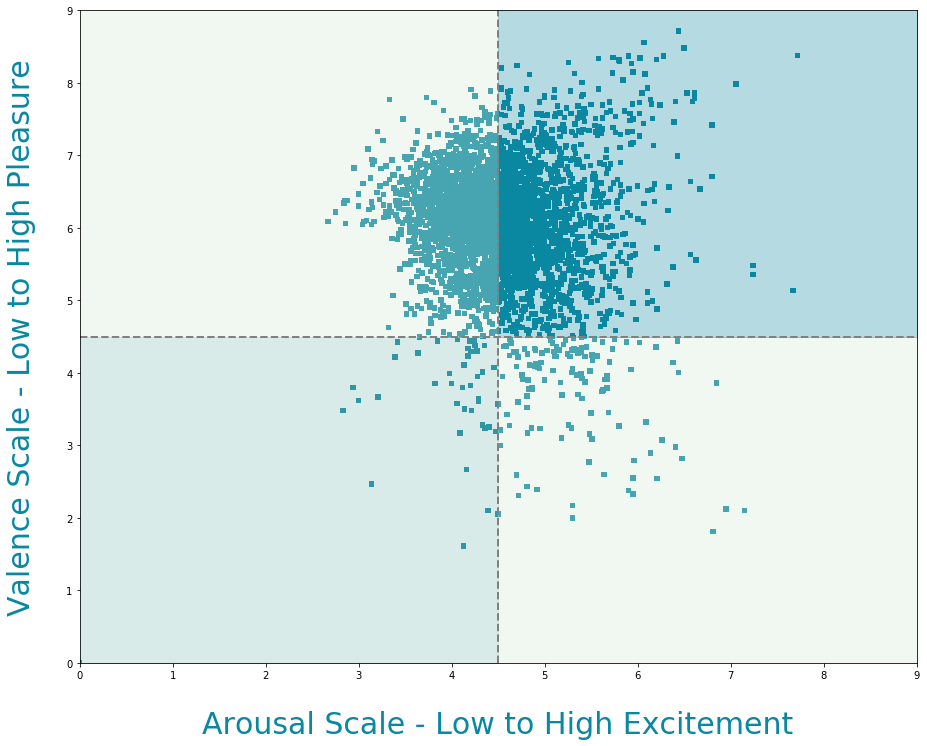

In [151]:
z = 4.5

fig,ax = plt.subplots(figsize=(15,12))
ax.set_xlim(0,9)
ax.set_ylim(0,9)

ax.scatter(total_arousal, total_valence, marker='s', s=30, c='#0A87A1', edgecolors='', lw=1)

ax.axvline(z,color = 'grey',linestyle='dashed',lw=2)
ax.axhline(z,color = 'grey',linestyle='dashed',lw=2)

ax.fill_between([0, z],0,z, alpha=0.3, color='#80BFB7')
ax.fill_between([z, 9], 0, z, alpha=0.3, color='#D2EBD5')  
ax.fill_between([0, z], z, 9, alpha=0.3, color='#D2EBD5') 
ax.fill_between([z, 9], z, 9, alpha=0.3, color='#0A87A1')  

plt.ylabel('Valence Scale - Low to High Pleasure', fontsize=30,labelpad=30, color='#0A87A1')
plt.xlabel('Arousal Scale - Low to High Excitement', fontsize=30,labelpad=30, color='#0A87A1')
#plt.title('Sentiment Analysis of iPhone Tweets', fontsize=40, pad=30, color='#0A87A1')
plt.show()

Building corpus for GenSim dictionary

In [16]:
corpus = [dict.doc2bow(text) for text in term_vec]

builing lda models for 5, 20 and 3 topics respectively and saving for recall

In [89]:
ldamodel5 = gensim.models.ldamodel.LdaModel(corpus, num_topics = 5, id2word=dict, passes=15)
ldamodel5.save('models/model5.gensim')

In [47]:
ldamodel20 = gensim.models.ldamodel.LdaModel(corpus, num_topics = 20, id2word=dict, passes=15)
ldamodel20.save('models/model20.gensim')

In [22]:
ldamodel3 = gensim.models.ldamodel.LdaModel(corp, num_topics = 3, id2word=dict, passes=30)
ldamodel3.save('models/model3.gensim')

loading the model with 3 topics to visualize

In [25]:
lda = gensim.models.ldamodel.LdaModel.load('models/model3.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dict, sort_topics=True)

/usr/local/anaconda3/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/anaconda3/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


vizualizing the model inline

In [153]:
pyLDAvis.display(lda_display)

sending the model to its own webpage for visualization

In [59]:
pyLDAvis.show(lda_display)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [21/Oct/2018 17:44:29] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Oct/2018 17:44:29] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [21/Oct/2018 17:44:30] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [21/Oct/2018 17:44:30] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [21/Oct/2018 17:44:30] code 404, message Not Found
127.0.0.1 - - [21/Oct/2018 17:44:30] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...


Building a list of top 30 terms from each topic to do sentiment analysis

Topic 1

In [137]:
topics1 = lda.show_topic(topicid=0, topn=30)
topic1_terms = []

for t in range(0, len(topics1)):
    topic1_terms.append(topics1[t][0])

Topic 2

In [138]:
topics2 = lda.show_topic(topicid=1, topn=30)
topic2_terms = []

for t in range(0, len(topics2)):
    topic2_terms.append(topics2[t][0])

Topic 3

In [139]:
topics3 = lda.show_topic(topicid=2, topn=30)
topic3_terms = []

for t in range(0, len(topics3)):
    topic3_terms.append(topics3[t][0])

In [140]:
print('topic 1')
print(topic1_terms)
print('topic 2')
print(topic2_terms)
print('topic 3')
print(topic3_terms)

topic 1
['case', 'appl', 'new', 'clear', 'get', 'price', 'buy', 'phone', 'x', 'launch', 'plan', 'around', '40', 'screen', 'want', 'use', '8', 'samsung', '9', 'rayito', '30', 'note', 'check', 'gold', 'one', 'plu', 'need', 'cover', 'amp', 'best']
topic 2
['pixel', '3', 'vs', 'appl', 'googl', 'camera', 'new', 'xl', 'case', 'get', 'stack', 'got', 'look', 'x', 'releas', 'differ', 'phone', 'win', 'love', 'still', 'better', 'via', 'photo', 'forc', 'galaxi', 'like', 'restart', 'enter', 'super', 'giveaway']
topic 3
['youtub', 'like', 'video', 'review', 'via', 'sale', 'appl', 'sell', 'foxconn', 'camera', 'q3', 'revenu', 'machin', 'walmart', 'hint', 'solid', 'man', 'unbox', 'china', 'go', '“', '”', 'littl', 'galaxi', 'phone', 'zurita', '‘', 'big', 'point', 'wife']


Getting the sentiment of the top 30 topic terms

In [141]:
arousal1 = []
valence1 = []

for i in topic1_terms:
    sent = sentiment.sentiment(i)
    arousal1.append(sent['arousal'])
    valence1.append(sent['valence'])

In [142]:
avg_a1 = stat.mean(arousal1)
avg_v1 = stat.mean(valence1)
print("Average arousal for Topic 1 is", avg_a1)
print("Average valence Topic 1 is", avg_v1)


Average arousal for Topic 1 is 2.599666666666667
Average valence Topic 1 is 3.7253333333333334


Getting the sentiment of the top 30 topic terms

In [143]:
arousal2 = []
valence2 = []

for i in topic2_terms:
    sent = sentiment.sentiment(i)
    arousal2.append(sent['arousal'])
    valence2.append(sent['valence'])

In [144]:
avg_a2 = stat.mean(arousal2)
avg_v2= stat.mean(valence2)
print("Average arousal for Topic 2 is", avg_a2)
print("Average valence Topic 2 is", avg_v2)


Average arousal for Topic 2 is 3.2476666666666665
Average valence Topic 2 is 4.242


Need to plot sentiment

Getting the sentiment of the top 100 topic terms

In [145]:
arousal3 = []
valence3 = []

for i in topic3_terms:
    sent = sentiment.sentiment(i)
    arousal3.append(sent['arousal'])
    valence3.append(sent['valence'])

In [146]:
avg_a3 = stat.mean(arousal3)
avg_v3 = stat.mean(valence3)
print("Average arousal for Topic 3 is", avg_a3)
print("Average valence Topic 3 is", avg_v3)


Average arousal for Topic 3 is 2.578666666666667
Average valence Topic 3 is 3.517


seeing if its worth vizualizing the topic sentiment

In [108]:
arousal = [avg_a1, avg_a2, avg_a3]
valence = [avg_a1, avg_a2, avg_a3]

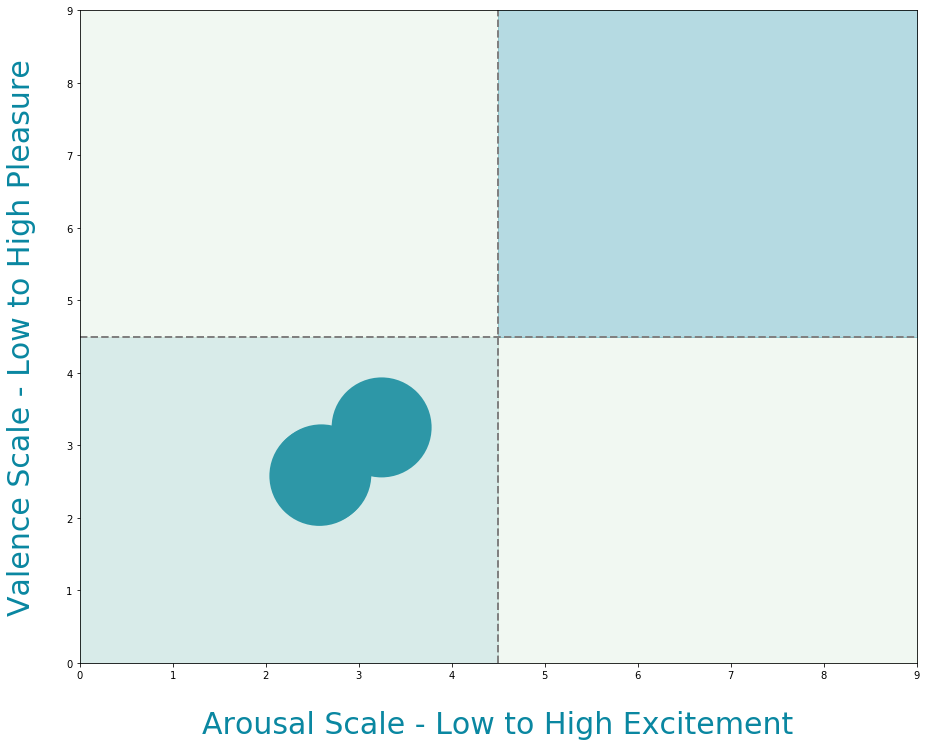

In [147]:
z = 4.5

fig,ax = plt.subplots(figsize=(15,12))
ax.set_xlim(0,9)
ax.set_ylim(0,9)

ax.scatter(arousal, valence, marker='o', s=10000, c='#0A87A1', edgecolors='', lw=1)

ax.axvline(z,color = 'grey',linestyle='dashed',lw=2)
ax.axhline(z,color = 'grey',linestyle='dashed',lw=2)

ax.fill_between([0, z],0,z, alpha=0.3, color='#80BFB7')
ax.fill_between([z, 9], 0, z, alpha=0.3, color='#D2EBD5')  
ax.fill_between([0, z], z, 9, alpha=0.3, color='#D2EBD5') 
ax.fill_between([z, 9], z, 9, alpha=0.3, color='#0A87A1')  

plt.ylabel('Valence Scale - Low to High Pleasure', fontsize=30,labelpad=30, color='#0A87A1')
plt.xlabel('Arousal Scale - Low to High Excitement', fontsize=30,labelpad=30, color='#0A87A1')
#plt.title('Sentiment Analysis of iPhone Tweets', fontsize=40, pad=30, color='#0A87A1')
plt.show()

topics = ['1', '2', '3']

for i, txt in enumerate(topics):
    ax.annotate(str(txt), (arousal[i], valence[i]))